## Calculating the distance to the Palomar 5 globular cluster (v2.0)

Author: Luke Bischoff<br>
Created: 18 DECEMBER 2020 10:48<br>
Updated: 18 DECEMBER 2020 11:57

##### Introduction
This document aims to measure the distance to the Palomar 5 (PAL5) globular cluster in the Milky Way Galaxy. This is achieved by using RR Lyrae variable stars within the cluster and analysing their apparent magnitudes and periods in the form of a PL relation. A plot of the RR Lyrae's individual average apparent magnitude against their period enables a PL relation to be fit to the data and compared to a calibrated PL relation, which is based in absolute magnitudes. The distance can then be calculated from the distance modulus.
##### Contents
1. List of python imports and modules<br>
2. User defined functions<br>
3. Initialisation and options<br>
3a. Initialisation: choosing globular cluster and channel information<br>
3b. Options: choosing photometry parameters<br>
4. Master source list: creating a list of all detected stars in the main frames<br>
5. Photometry: performing photometry on epoch data and matching to master source list (optimised for PSF only)<br>
6. Raw light curves: constructs raw light curves for identified RR Lyraes<br>
7. GLOESS analysis: constructs light curves with a smoothing function and returns average magnitudes and uncertainties<br>
8. PL relations: fits PL relations for the data in each channel and returns distances<br>

##### Import list

In [32]:
import math
import glob
import copy
import numpy as np
import pandas as pd
import astroalign as aa
import matplotlib
import matplotlib.pyplot as plt
from gloess_plot import GLOESSpy
from scipy.optimize import curve_fit
from astropy import wcs
from astropy import units as u
from astropy.io import fits # used for FITS file management
from astropy.io import ascii
from astropy.time import Time
from astropy.stats import sigma_clipped_stats # used within star detection
from astropy.table import Table, join
from astropy.nddata import NDData
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.coordinates import Angle
from astropy.visualization import simple_norm
from astropy.io.votable import parse_single_table
from astropy.modeling.fitting import LevMarLSQFitter
from photutils import aperture_photometry # used to perform photometry using annuli
from photutils import DAOStarFinder # used for the star finding algorithm
from photutils import CircularAperture, CircularAnnulus
from photutils import EPSFBuilder
from photutils.psf import extract_stars
from photutils.psf import DAOGroup
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground
from astroquery.irsa_dust import IrsaDust
from matplotlib import rc
from matplotlib.colors import LogNorm

plt.rcParams.update({'font.size': 18})
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

##### Function list

In [2]:
## COORDINATE CONVERSION ##
def Coord_Conv(header, x_list, y_list):
    # CONVERTS COORDINATES IN X, Y TO RIGHT ASCENSION AND DECLINATION USING ICRS COORDINATES
    # header: INPUT HEADER REFERENCE TO OBTAIN WCS
    # x_list, y_list: LIST OF X AND Y COORDINATES TO BE CONVERTED
    w = wcs.WCS(header)
    coord = np.transpose((x_list, y_list))
    world = w.wcs_pix2world(coord, 0)
    ra, dec = world[:, 0], world[:, 1]
    c = SkyCoord(ra, dec, frame = 'icrs', unit = 'deg')
    return ra, dec, c

##### Initialisation and options

In [3]:
## INPUT DATA PATHS ##

cluster_input = 'PAL5'

if cluster_input == 'PAL5':
    epoch_path = 'PAL5_data/*/'
    master_path = 'PAL5_data/PAL5/'
    general_path = 'PAL5_data/'
elif cluster_input == 'PAL13':
    epoch_path = 'PAL13_data/*/'
    master_path = 'PAL13_data/PAL13/'
    general_path = 'PAL13_data/'
elif cluster_input == 'IC4499':
    epoch_path = 'IC4499_data/*/'
    master_path = 'IC4499_data/IC4499/'
    general_path = 'IC4499_data/'
else:
    raise ValueError('Cluster not found: input clusters `PAL5`, `PAL13` or `IC4499` only!')

## CHANNEL ##

channel = '3p6um'

if channel == '3p6um':
    aper_corr = 1.1233            # aperture correction for 337 (6,6,14) apertures in channel 1, c.f IRAC handbook §4.10
    ap_err    = aper_corr * 0.02  # uncertainty to ~2% as per IRAC handbook
    zmag      = 18.80             # zeropoint magnitude given in IRAC handbook §4.8
    zmag_err  = 0.02              # uncertainty calculated from F0 = 280.9 +/- 4.1 in IRAC handbook
elif channel == '4p5um':
    aper_corr = 1.1336
    ap_err    = aper_corr * 0.02
    zmag      = 18.32
    zmag_err  = 0.02
else:
    raise ValueError('Incorrect channel input: only values 3p6um or 4p5um permitted.')
    
## PHOTOMETRY PARAMETERS AND OPTIONS ##

fwhm = 5.               # APPROX. FULL-WIDTH AT HALF-MAXIMUM FOR SAMPLE OF STARS
sigma = 6.              # SIGMA VALUE FOR MASTER STAR LIST AND PHOTOMETRY STAR DETECTION AND SIGMA-CLIPPING
sigma_epsf = 50.        # SIGMA VALUE FOR ePSF MODEL STAR DETECTION
r_ap = 6.               # APERTURE RADIUS AROUND DETECTED SOURCE
r_in = 6.               # INNER RADIUS FOR STAR ANNULI
r_out = 14.             # OUTER RADIUS FOR STAR ANNULI
roundlo = -0.5          # ROUND VALUE FOR STAR DETECTION ALGORITHM
roundhi = +0.5
sharphi = 0.9           # SHARP VALUE FOR PHOTOMETRY STAR DETECTION
sharphi_model = 0.8     # SHARP VALUE FOR ePSF MODEL STAR DETECTION

phot_method = 'psf'     # SELECT PHOTOMETRY METHOD: 'aperture' or 'psf'

##### Master source list

In [ ]:
## BUILDING MASTER SOURCE LIST USING MOSAICKED IMAGE ##

master_file = master_path+cluster_input+'_'+channel+'.fits'

## OPENING FITS FILE AND EXTRACTING DATA ##

with fits.open(master_file) as hdr_list:
    m_hdr = hdr_list[0].header
    counts = m_hdr['EXPTIME'] / m_hdr['FLUXCONV']
    im_data = fits.getdata(master_file, ext = 0)
    m_data = im_data * counts
    print('FITS file information:\nFILE = {0}\n'.format(master_file))

## BUILDING ePSF FOR MASTER FILE ##

mean_epsf, median_epsf, std_epsf = sigma_clipped_stats(m_data, sigma = sigma) # sigma-clipping on data

starfind_init = DAOStarFinder(fwhm = fwhm, threshold = sigma_epsf * std_epsf, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi_model)
epsf_sources = starfind_init(m_data)
print('Number of ePSF sources found = {0}\n'.format(len(epsf_sources)))

## STAR CUTOUTS FOR ePSF ##

cutout_size = 200
hsize = (cutout_size - 1) / 2
x = epsf_sources['xcentroid']
y = epsf_sources['ycentroid']
mask = ((x > hsize) & (x < (m_data.shape[1] - 1 - hsize)) &
        (y > hsize) & (y < (m_data.shape[0] - 1 - hsize)))

star_tbl = Table()       # build table of star sources
star_tbl['x'] = x[mask]
star_tbl['y'] = y[mask]
star_tbl['id'] = range(len(star_tbl))
print('Number of refined ePSF sources = {0}\n'.format(len(star_tbl)))

## EXTRACT STARS ##

epsf_data = m_data - median_epsf
while True:
    nddata = NDData(data = epsf_data)
    epsf_stars = extract_stars(nddata, star_tbl, size = 25)

    ## VISUALISE MODEL STARS ##
    
    ncols = 6
    nrows = int(np.floor(len(epsf_stars) / ncols))
    remaining = len(epsf_stars) - ncols * nrows

    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20), squeeze = True)
    ax = ax.ravel()
    for i in range(nrows * ncols):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i].set_title([i])
    plt.show()
    for i in range(ncols * nrows, len(epsf_stars)):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i - ncols * nrows].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i - ncols * nrows].set_title([i])
    plt.show()
    plt.close()
    
    ## BUILD ePSF ##

    epsf_builder = EPSFBuilder(oversampling = 2, maxiters = 10, progress_bar = True)
    epsf, fitter = epsf_builder(epsf_stars)
    
    norm = simple_norm(epsf.data, 'log', percent = 99.)
    plt.imshow(epsf.data, cmap = 'viridis', norm = norm, origin = 'lower')
    plt.title('constructed ePSF model')
    plt.colorbar()
    plt.show()
    
    print('Remove any poor quality model stars from the model by their ID. Use ID -99 to escape')
    remove = [int(k) for k in input().split()]
    
    if remove == [-99]:
        print('Escape completed\n')
        break
    
    star_tbl.add_index('id')
    bad_id = star_tbl.loc_indices[remove]
    star_tbl.remove_rows(bad_id)

    
## SOURCE DETECTION ##

mean_m, median_m, std_m = sigma_clipped_stats(m_data, sigma = sigma)

master_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma * std_m, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
master_sources = master_daofind(m_data)

# PLOT INITIAL DETECTED SOURCES
master_positions = np.transpose((master_sources['xcentroid'], master_sources['ycentroid']))
master_apertures = CircularAperture(master_positions, r = r_ap)

plt.imshow(m_data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
master_apertures.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Detected MASTER stars: threshold {0} * std, fwhm = {1}, round = ±{2}, sharphi = {3}'
          .format(sigma, fwhm, roundhi, sharphi))
plt.minorticks_on()
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .25, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()
plt.close()
print('Number of MASTER stars detected = {0}\n'.format(len(master_sources)))

## RENAME STAR LIST HEADERS ##

master_sources['xcentroid'].name = 'x_0'
master_sources['ycentroid'].name = 'y_0'
master_sources['id'].name = 'master_id'

## PSF ROUTINE ON MASTER LIST ##

daogroup = DAOGroup(crit_separation = sigma * fwhm)

data_psf_m = np.nan_to_num(m_data, nan = 1**-7)

epsf.x_0.fixed = True
epsf.y_0.fixed = True
pos_init_m = Table(names = ['x_0', 'y_0'], data = [master_sources['x_0'], master_sources['y_0']])

PSF_photometry = IterativelySubtractedPSFPhotometry(finder = master_daofind,
                                                    group_maker = daogroup,
                                                    bkg_estimator = MMMBackground(),
                                                    psf_model = epsf,
                                                    fitter = LevMarLSQFitter(),
                                                    niters = 2,
                                                    aperture_radius = r_ap,
                                                    fitshape = (11, 11))

m_phot = PSF_photometry(image = data_psf_m, init_guesses = pos_init_m)
residual_image = PSF_photometry.get_residual_image()

print('Number of MASTER stars found from PSF = {0}\n'.format(len(m_phot)))

## COORDINATE CONVERSION ##

master_list = copy.copy(m_phot)
del master_list['flux_0', 'group_id', 'x_fit', 'y_fit', 'flux_fit', 'flux_unc', 'iter_detected']
master_list['id'].name = 'phot_id'

master_list['master_id'] = int(0)
for i in range(len(master_list)):
    master_list['master_id'][i] = i
    
del master_list['phot_id']
new_order = ['master_id', 'x_0', 'y_0']
master_list = master_list[new_order]

ra_m, dec_m, c_m = Coord_Conv(m_hdr, master_list['x_0'], master_list['y_0'])

master_list['ra'] = ra_m
master_list['dec'] = dec_m

## EXPORT AND SAVE FILE -- SHOW IN NOTEBOOK ##

master_list.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\{0}_master_list_{1}.txt'.format(cluster_input, channel), format = 'csv', overwrite = True)

master_list.show_in_notebook()

##### Photometry

In [ ]:
## PHOTOMETRY ON EPOCHS ##

## INITIALISE MAIN TABLE ##

main_table = copy.copy(master_list)

## STORE EPOCH TIMES AS MODIFIED JULIAN DATE [MJD] ##

lctime = []

## EPOCH LOOP COUNTER ##

epoch = 0

## PHOTOMETRY LOOP ##

path1 = epoch_path+cluster_input+'__e[0-9]_'+channel+'.fits'
path2 = epoch_path+cluster_input+'__e[0-9][0-9]_'+channel+'.fits'

for file in glob.glob(path1, recursive = True) + glob.glob(path2, recursive = True):
    epoch += 1
    print('EPOCH NUMBER = {0}\n'.format(epoch))
    ## OPENING FITS FILE AND EXTRACTING DATA ##
    with fits.open(file) as hdr_list:
        e_hdr = hdr_list[0].header
        counts = e_hdr['EXPTIME'] / e_hdr['FLUXCONV']
        time = Time(e_hdr['DATE_OBS'])
        
        im_data = fits.getdata(file, ext = 0)
        e_data = im_data * counts
        
        print('FITS file information:\nFILE = {0}\nDATE = {1}\n\n'.format(file, time))
    
    ## EXTRACT TIME FROM EPOCH ##
    
    lctime.append(Time(e_hdr['DATE_OBS'], format = 'isot', scale = 'utc').mjd)
    
    ## EXTRACTING LOC-DEPENDENT CORRECTION ##
    corr_file = general_path+cluster_input+'__e'+str(epoch)+'/'+cluster_input+'__e'+str(epoch)+'_correction_'+channel+'.fits'
    with fits.open(corr_file) as hdu_list:
        corr_data = hdu_list[0].data
    
    mean_val, median_val, std_val = sigma_clipped_stats(e_data, sigma = sigma)

    ## PHOTOMETRY LOOP ##
    if phot_method == 'aperture':
        ## SOURCE DETECTION ON IMAGE ##
        daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma * std_val, roundlo = roundlo, roundhi = roundhi)
        sources = daofind(data) #- median_val) # necessary here?
        print('Number of stars detected: {}'.format(len(sources)))
        positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
        apertures = CircularAperture(positions, r = r_ap)

        plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
        plt.colorbar(fraction = 0.05)
        apertures.plot(color = 'black', lw = 1., alpha = .75)
        plt.title('Aperture photometry on epoch {} in channel {}: sigma = {}, fwhm = {}, roundlo = {}, roundhi = {}'
                  .format(j, channel, sigma_val, fwhm, roundlo, roundhi))
        plt.grid(b = True, which = 'major', lw = .5, alpha = .4, color = 'black')
        plt.gcf().set_size_inches(15, 8)
        plt.show()
        plt.close()
        
        ## APERTURE PHOTOMETRY ##
    
        positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
        circular_apertures = CircularAperture(positions, r = r_ap)
        annuli_apertures = CircularAnnulus(positions, r_in = r_in, r_out = r_out)
        apertures = [circular_apertures, annuli_apertures]

        # INITIAL APERTURE PHOTOMETRY TABLE
        phot_init = aperture_photometry(e_data, apertures)

        # BACKGROUND SUBTRACTION USING SIGMA-CLIPPING
        annulus_masks = annuli_apertures.to_mask(method = 'center')

        bkg_median = []
        for mask in annulus_masks:
            annulus_data = mask.multiply(e_data)
            annulus_data_1d = annulus_data[mask.e_data > 0] # extract 1D array of data values
            _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d) # utilise sigma clipping on the annulus masks
            bkg_median.append(median_sigclip)

        bkg_median = np.array(bkg_median)
        # APPEND bkg_median, aperture background AND aperture sum background VALUES TO PHOTOMETRY DATA
        phot_init['annulus_median'] = bkg_median
        phot_init['aper_bkg'] = bkg_median * circular_apertures.area
        phot_init['aper_sum_bkgsub'] = phot_init['aperture_sum_0'] - phot_init['aper_bkg']
        
        ## PHOTOMETRY: UNCERTAINTIES ##

        # THIS FOLLOWS  §2 (pp 8) OF Reach et al 2005
        mean_bkg = phot_init['aperture_sum_1'] / annuli_apertures.area
        median_bkg = bkg_median

        bkg_sub_err = median_bkg * circular_apertures.area / pow(annuli_apertures.area, 0.5)
        sky_err = median_bkg * pow(circular_apertures.area, 0.5)
        poisson_err = pow(phot_init['aper_sum_bkgsub'], 0.5)

        aper_err = pow(bkg_sub_err**2 + sky_err**2 + poisson_err**2, 0.5)

        ## APPARENT MAGNITUDE ##

        phot = phot_init                    
        phot['apparent_mag'] = float('NaN')

        for i in range(0, len(phot)):
            # APPLY ARRAY-LOC DEP CORRECTION
            loc_corr = corr_data[int(phot['ycenter'][i].value)][int(phot['xcenter'][i].value)]
            if phot['aper_sum_bkgsub'][i] >= 0:
                phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['aper_sum_bkgsub'][i] * aper_corr * loc_corr / counts)

        ## APPARENT MAGNITUDE: UNCERTAINTIES ##

        phot['apparent_mag_err'] = float('Nan')
        for i in range(0, len(phot)):
            phot['apparent_mag_err'][i] = pow(zmag_err**2 + (2.5*(pow((aper_err[i] / aper_sum_bkgsub[i])**2 + (ap_err / aper_corr)**2, 0.5) / (np.log(10)))**2), 0.5)
        #NOTE: APERTURE PHOTOMETRY MAY BE REMOVED LATER - WORK FOCUSED ON PSF PHOTOMETRY FOR REST OF PROJECT
    
    elif (phot_method == 'psf' or phot_method == 'PSF'):
        ## SOURCE DETECTION ON IMAGE ## 
        psf_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma * std_val, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
        psf_sources = psf_daofind(e_data)
        print('Number of inital stars detected = {0}\n'.format(len(psf_sources)))
        
        ## GROUP ## 
        psf_sources['xcentroid'].name = 'x_0'
        psf_sources['ycentroid'].name = 'y_0'
        
        daogroup = DAOGroup(crit_separation = sigma * fwhm)
        
        data_psf = np.nan_to_num(e_data, nan = 1**-7)
        
        epsf.x_0.fixed = True
        epsf.y_0.fixed = True
        init_pos = Table(names = ['x_0', 'y_0'], data = [psf_sources['x_0'], psf_sources['y_0']])
        
        ## PERFORMING PSF PHOTOMETRY ##

        PSF_photometry = IterativelySubtractedPSFPhotometry(finder = psf_daofind,
                                                            group_maker = daogroup,
                                                            bkg_estimator = MMMBackground(),
                                                            psf_model = epsf,
                                                            fitter = LevMarLSQFitter(),
                                                            niters = 2,
                                                            aperture_radius = r_ap,
                                                            fitshape = (11, 11))

        result_phot = PSF_photometry(image = data_psf, init_guesses = init_pos)
        residual_image = PSF_photometry.get_residual_image()
        
        print('Number of PSF stars found and analysed = {0}\n'.format(len(result_phot)))
        
        phot = result_phot   # REDEFINE PHOTOMETRY TABLE FOR EASE
        
        PSF_err = phot['flux_unc']
        PSF_flux = phot['flux_fit']
        
        ## APPARENT MAGNITUDES ##
    
        phot['apparent_mag'] = float('NaN')
        for i in range(0, len(phot)):
            # APPLY ARRAY-LOC DEP CORRECTION
            loc_corr = corr_data[int(phot['y_fit'][i])][int(phot['x_fit'][i])]
            if phot['flux_fit'][i] >= 0:
                phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['flux_fit'][i] * aper_corr * loc_corr / counts)
        
        ## APPARENT MAGNITUDE: UNCERTAINTIES ##
    
        phot['apparent_mag_unc'] = float('NaN')
        for i in range(0, len(phot)):
            if phot['flux_fit'][i] >= 0:
                phot['apparent_mag_unc'][i] = pow(zmag_err**2 + (2.5*(pow((PSF_err[i] / PSF_flux[i])**2 + (ap_err / aper_corr)**2, 0.5) / (np.log(10)))**2), 0.5)
            
        ## CONVERT COORDINATES ##
        
        ra_e, dec_e, c_e = Coord_Conv(e_hdr, phot['x_fit'], phot['y_fit'])

        phot['ra'] = ra_e
        phot['dec'] = dec_e
        
        ## APPEND APPARENT MAGNITUDE AND UNCERTAINTY COLUMNS FOR EACH EPOCH ##
        
        epoch_table = copy.copy(phot)
        # DELETE CERTAIN COLUMNS TO AVOID CRAMMING NEW EPOCH TABLE
        del epoch_table['x_0', 'y_0', 'flux_0', 'flux_unc', 'iter_detected']
        epoch_mag = 'mag_e'+str(epoch)
        epoch_unc = 'unc_e'+str(epoch)
        epoch_ra = 'ra_e'+str(epoch)
        epoch_dec = 'dec_e'+str(epoch)
        # RENAME COLUMNS FOR EASE
        epoch_table.rename_column('ra', epoch_ra)
        epoch_table.rename_column('dec', epoch_dec)
        epoch_table.rename_column('apparent_mag', epoch_mag)
        epoch_table.rename_column('apparent_mag_unc', epoch_unc)
        epoch_table.rename_column('x_fit', 'xcenter')
        epoch_table.rename_column('y_fit', 'ycenter')
        
        #epoch_table.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\troubleshooting\e{0}_result_phot_{1}.txt'.format(epoch, channel), format = 'csv', overwrite = True)
        
        ## PHOTOMETRY COMPLETE -- APPARENT MAGNITUDES AND UNCERTAINTIES OBTAINED FOR ALL EPOCHS ##
        
    else:
        raise ValueError('Incorrect photometry method input! Input only value `psf`')
    
    ## MATCH STARS FROM EPOCHS TO MASTER STAR LIST ##
    
    conv_table = copy.copy(main_table)
    
    ra, dec, c = Coord_Conv(e_hdr, epoch_table['xcenter'], epoch_table['ycenter'])

    epoch_table['ra'] = ra
    epoch_table['dec'] = dec
    #epoch_table.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\troubleshooting\e{0}_result_phot_22222_{1}.txt'.format(epoch, channel), format = 'csv', overwrite = True)
    idx, d2d, d3d = c.match_to_catalog_sky(c_m)
    
    # ENSURE MATCHES ARE SIGNIFICANT
    rad = 0.25 * u.arcsec
    selection = (d2d > rad)
    match_index = idx
    match_index[selection] = -99.
    matches = ((match_index >= 0))
    
    epoch_table = epoch_table[matches]
    conv_table = conv_table[match_index][matches]
    
    # ASSIGN EPOCH TABLE ID EQUIVALENT TO MASTER ID
    epoch_table['master_id'] = conv_table['master_id']
    
    epoch_table = Table(epoch_table, masked = True)
    
    main_table = join(main_table, epoch_table['master_id', epoch_mag, epoch_unc], keys = 'master_id', join_type = 'left')
    
    print(main_table)
    
    main_table.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\{0}_interim_phot_epoch{1}_{2}.txt'.format(cluster_input, epoch, channel), format = 'csv', overwrite = True)
    
main_table.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\{0}_main_phot_{1}.txt'.format(cluster_input, channel), format = 'csv', overwrite = True)
main_table.show_in_notebook()

##### Raw light curves

Gaia detected stars in PAL5:

     source_id              ra                 dec         
                           deg                 deg         
------------------- ------------------ --------------------
4418724034151291776  229.0395752980474 -0.27315259808741965
4418726027016125056 229.05318546815684 -0.16753341271842292
4418725232446508032  229.0104637260607  -0.2242677694891892
4418731829516302848 229.09705423020364  -0.1419234982327973
4418920808077110784 228.99266625761803 -0.09659804838365565
4418913218870688768 228.99144962264384 -0.18985356481473498
4418920846732620032 228.99634825110095 -0.08977613143985393
4418914863842345856 228.98840114088054 -0.11479928258025933


RR Lyrae catalogue for PAL5:

   id           ra          dec  period type   ra_deg   dec_deg
0   0  15:15:57.18  -00:06:53.3  0.2932  RR1  228.988 -0.114806
1   1  15:15:57.95  -00:11:23.4  0.3325  RR1  228.991 -0.189833
2   2  15:16:12.76  -00:10:03.3  0.3300  RR1  229.053 -0.167583
3   3  15:16:05.79  -0

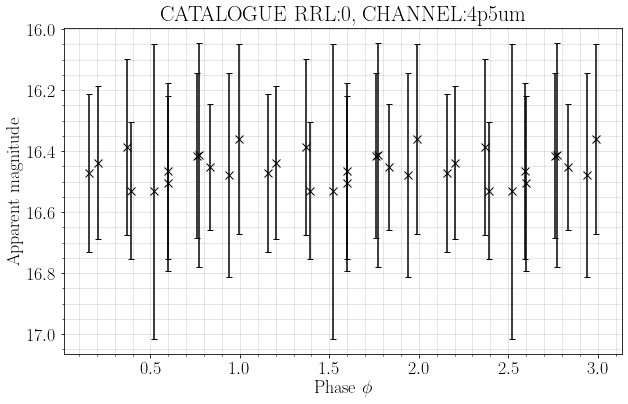

RRL Catalogue ID: 1

Gaia source_id = 4418913218870688768

     source_id              pf                pf_error              p1_o              p1_o_error       p2_o p2_o_error best_classification
                            d                    d                   d                    d             d       d                         
------------------- ------------------ --------------------- ------------------ ---------------------- ---- ---------- -------------------
4418913218870688768 0.4560492745060416 5.359142131960588e-05 0.3324598951039927 1.1762566665534304e-06   --         --                 RRd


RRL classification: RRc

Source ID: 626

master_id         ra                 dec        
--------- ------------------ -------------------
      626 228.99148953677985 -0.1897417002323174




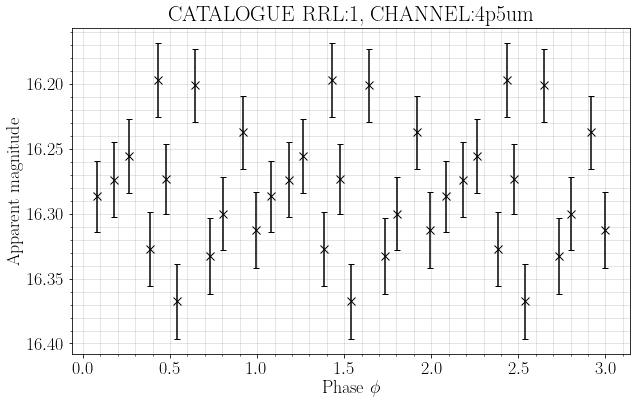

RRL Catalogue ID: 2

Gaia source_id = 4418726027016125056

     source_id       pf pf_error         p1_o              p1_o_error       p2_o p2_o_error best_classification
                     d     d              d                    d             d       d                         
------------------- --- -------- ------------------- ---------------------- ---- ---------- -------------------
4418726027016125056  --       -- 0.32994609655420243 2.3375525458486275e-06   --         --                 RRc


RRL classification: RRc

Source ID: 95

master_id         ra                 dec         
--------- ------------------ --------------------
       95 229.05323447077396 -0.16744948177375027




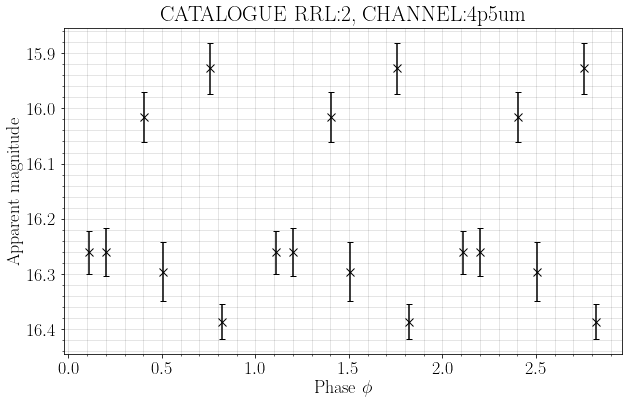

RRL Catalogue ID: 3

Source ID: 227

master_id         ra                 dec         
--------- ------------------ --------------------
      227 229.02412287681852 -0.18677467881889154




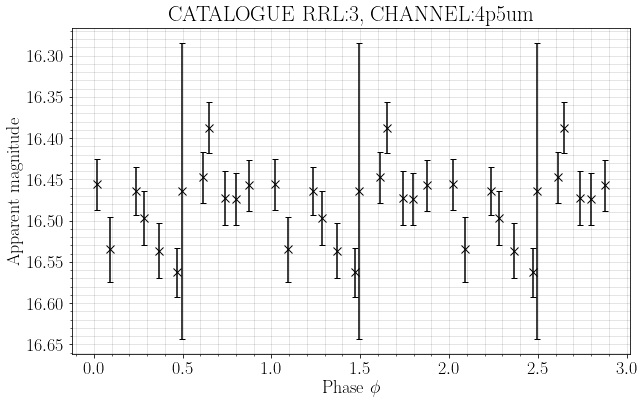

RRL Catalogue ID: 4

Gaia source_id = 4418920808077110784

     source_id       pf pf_error        p1_o              p1_o_error      p2_o p2_o_error best_classification
                     d     d             d                    d            d       d                         
------------------- --- -------- ------------------ --------------------- ---- ---------- -------------------
4418920808077110784  --       -- 0.3379328972183922 5.549092142819596e-07   --         --                 RRc


RRL classification: RRc

Source ID: 554

master_id         ra                 dec        
--------- ------------------ -------------------
      554 228.99270066327517 -0.0964933257929539




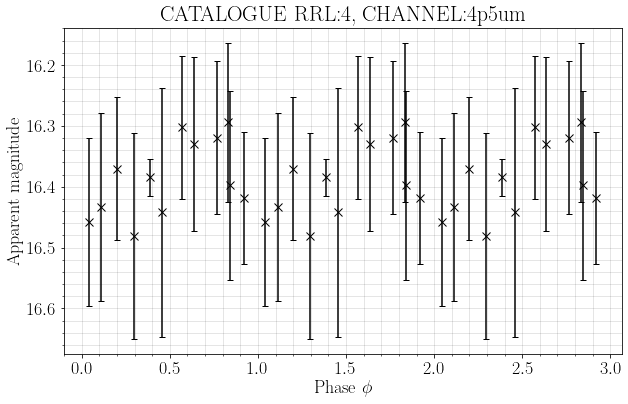

RRL Catalogue ID: 5

Gaia source_id = 4418920846732620032

     source_id              pf                pf_error       p1_o p1_o_error p2_o p2_o_error best_classification
                            d                    d            d       d       d       d                         
------------------- ------------------ --------------------- ---- ---------- ---- ---------- -------------------
4418920846732620032 0.6432279274597504 4.230532863862018e-06   --         --   --         --                RRab


RRL classification: RRab

Source ID: 547

master_id         ra                 dec         
--------- ------------------ --------------------
      547 228.99636759964145 -0.08971053090360367




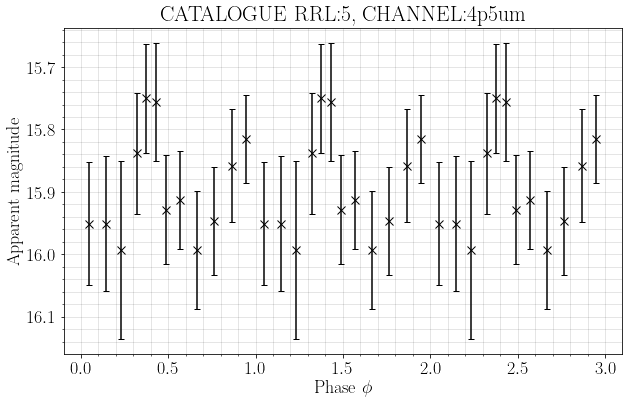

RRL Catalogue ID: 6

Gaia source_id = 4418724034151291776

    source_id              pf                pf_error        p1_o p1_o_error p2_o p2_o_error best_classification
                           d                    d             d       d       d       d                         
------------------ ------------------ ---------------------- ---- ---------- ---- ---------- -------------------
199145955502847232 0.6199447585415945 1.5842050291046584e-05   --         --   --         --                RRab


RRL classification: RRab

Source ID: 67

master_id         ra                 dec        
--------- ------------------ -------------------
       67 229.03963539044383 -0.2730844231070831




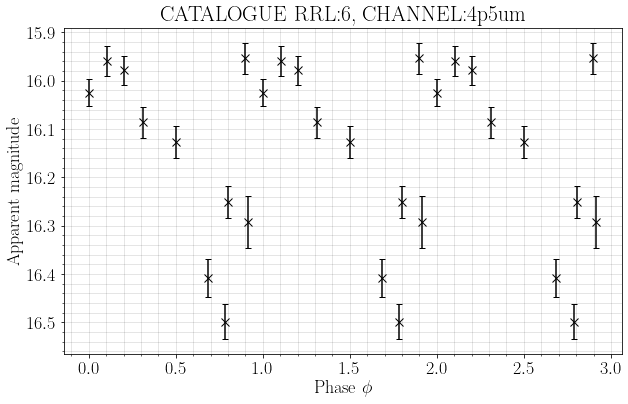

In [35]:
## LIGHT CURVE ANALYSIS ##

# OPTIONS
cluster       = cluster_input
channel       = '4p5um'
epoch_path    = epoch_path
main_file     = 'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/'+cluster+'_main_phot_'+channel+'.txt'
path1, path2  = epoch_path+cluster_input+'__e[0-9]_'+channel+'.fits', epoch_path+cluster+'__e[0-9][0-9]_'+channel+'.fits'

list_ch1 = []
list_ch2 = []

## READ IN MAIN TABLE AND GLOBULAR CLUSTER CATALOGUE ##

main_table = ascii.read(main_file, delimiter = ',', data_start = 1)

cat_file = 'CCVS_data/CCVS_'+cluster+'_RRLs_data.txt'
df_cat = ascii.read(cat_file, delimiter = ',', data_start = 1)

## CONVERT RA (UNITS: HMS) TO DEGREES AND DEC (UNITS: DMS) TO DEGREES ##

df_cat['ra_deg'] = str('null')
df_cat['dec_deg'] = str('null')
    
for col in df_cat.itercols():
    if col.dtype.kind in 'SU':
        df_cat.replace_column(col.name, col.astype('object'))
            
for i in range(len(df_cat)):
    ra_hms = Angle(df_cat['ra'][i], u.hour)
    df_cat['ra_deg'][i] = ra_hms.to_string(unit = u.deg, decimal = True)
for i in range(len(df_cat)):
    dec_hms = Angle(df_cat['dec'][i], u.degree)
    df_cat['dec_deg'][i] = dec_hms.to_string(unit = u.deg, decimal = True)

## WRITE TO NEW FILE : USE IN LIGHT CURVES ##

df_cat.write('CCVS_data/CCVS_{0}_RRLs_data_readin.txt'.format(cluster), format = 'csv', overwrite = True)

## READ IN GAIA DATA FOR STARS <10ARCMIN RADIUS OF PAL5 ##

vot_file = 'gaia_data/'+cluster+'_data/gaia_dr2_PAL5_read.vot'
votable = parse_single_table(vot_file).to_table()
gaia_data = votable
print('Gaia detected stars in {0}:\n'.format(cluster))
print(gaia_data['source_id', 'ra', 'dec']); print('\n')

## READ IN STAR CATALOGUE FROM CHRISTINE CLEMENT ##

rrl_cat = pd.read_csv('CCVS_data/CCVS_'+cluster+'_RRLs_data_readin.txt', sep = ',', header = 0)
print('RR Lyrae catalogue for {0}:\n'.format(cluster))
print(rrl_cat); print('\n')

## INITIALISE COORDINATE TRANSFORM/MATCHING ##

coord_rrl = SkyCoord(rrl_cat['ra_deg'], rrl_cat['dec_deg'], unit = u.degree)
coord_main = SkyCoord(main_table['ra'], main_table['dec'], unit = u.degree)
coord_gaia = SkyCoord(gaia_data['ra'], gaia_data['dec'], unit = u.degree)

## LOOP THROUGH ALL KNOWN RRLs AND PLOT LIGHT-CURVE ##
for i in range(len(rrl_cat)):
    target_rrl = i
    print('RRL Catalogue ID: {0}\n'.format(target_rrl))
    c = coord_rrl[target_rrl]
    
    source_id, d2d, d3d = c.match_to_catalog_sky(coord_gaia)
    rad = 1. * u.arcmin
    
    if (d2d < rad):
        
        gaia_source = gaia_data[source_id]['source_id']
        print('Gaia source_id = {0}\n'.format(gaia_source))
        
        ## READ IN ALL GAIA DR2 VARIABLE STARS [140784 stars] ##

        vot_file1 = 'gaia_data/'+cluster+'_data/gaia_dr2_rrls.vot'
        votable = parse_single_table(vot_file1).to_table()
        gaia_main = votable

        ## MATCH GAIA source_id TO STARS IDENTIFIED AROUND PAL5 ##

        for idx in range(len(gaia_main)):
            if gaia_main[idx]['source_id'] == gaia_source:
                main_id = idx
        print(gaia_main[main_id])
        print('\n')

        ## EXTRACT PERIODS FROM GAIA DATA ##
        ## IDENTIFY WHETHER FUNDAMENTAL OR FIRST OVERTONE ##

        if type(gaia_main[main_id]['pf']) == np.float64:
            rrl_class = 'RRab'
            P = gaia_main[main_id]['pf']
            P_err = gaia_main[main_id]['pf_error']
        elif type(gaia_main[main_id]['pf']) == np.ma.core.MaskedConstant:
            pass
        if type(gaia_main[main_id]['p1_o']) == np.float64:
            rrl_class = 'RRc'
            P = gaia_main[main_id]['p1_o']
            P_err = gaia_main[main_id]['p1_o_error']
        elif type(gaia_main[main_id]['p1_o']) == np.ma.core.MaskedConstant:
            pass
        print('RRL classification: {0}\n'.format(rrl_class))
        
        ## MATCH CATALOGUE TO MASTER SOURCE LIST ##

        main_id, d2d, d3d = c.match_to_catalog_sky(coord_main)
        if (d2d > 0.5 * u.arcmin):
            print('No match found to main photometry file. Select different channel.\n')
        else:
            print('Source ID: {0}\n'.format(main_id))
            print(main_table[main_id]['master_id', 'ra', 'dec'])
            print('\n')

            ## LIGHT CURVE TIME AND PHASE ##

            lctime = []

            for file in glob.glob(path1) + glob.glob(path2):
                with fits.open(file) as hdr_list:
                    e_hdr = hdr_list[0].header
                    lctime.append(Time(e_hdr['DATE_OBS'], format = 'isot', scale = 'utc').mjd)

            phase = []

            for i in lctime:
                func = i / P
                phase_val = func - np.floor(func)
                phase.append(phase_val)

            ## EXTRACTING MAGS AND UNCERTAINTIES FOR PLOT ##

            mag = []
            unc = []
            for i in range(1, 13):
                mag.append(main_table[main_id]['mag_e'+str(i)])
                unc.append(main_table[main_id]['unc_e'+str(i)])

            ## PLOT LIGHT CURVE ##

            lc_table = copy.copy(main_table.filled(-99))

            mag = np.ma.array(mag)
            mag = np.ma.masked_where(mag == -99, mag)
            unc = np.ma.array(unc)
            unc = np.ma.masked_where(unc == -99, unc)
            phase = np.ma.masked_array(phase, mag.mask)

            mag_long = np.concatenate((mag, mag, mag))
            unc_long = np.concatenate((unc, unc, unc))
            phase_long = np.concatenate((phase, phase + 1., phase + 2.))

            plt.errorbar(x = phase_long, y = mag_long, xerr = None, yerr = unc_long, fmt = 'kx', markersize = 8, capsize = 3)
            plt.xlabel(r'Phase $\phi$')
            plt.ylabel(r'Apparent magnitude')
            plt.title(r'CATALOGUE RRL:{0}, CHANNEL:{1}'.format(target_rrl, channel))
            plt.minorticks_on()
            plt.grid(b = True, which = 'major', lw = .5, alpha = .2, color = 'black')
            plt.grid(b = True, which = 'minor', lw = .5, alpha = .2, color = 'black')
            plt.gca().invert_yaxis()
            plt.gcf().set_size_inches(10, 6)
            plt.show()
            plt.close()

    else:
        P = rrl_cat['period'][target_rrl]
        
        ## MATCH CATALOGUE TO MASTER SOURCE LIST ##

        main_id, d2d, d3d = c.match_to_catalog_sky(coord_main)
        if (d2d > 0.5 * u.arcmin):
            print('No match found to main photometry file. Select different channel.\n')
        else:
            print('Source ID: {0}\n'.format(main_id))
            print(main_table[main_id]['master_id', 'ra', 'dec'])
            print('\n')

            ## LIGHT CURVE TIME AND PHASE ##

            lctime = []

            for file in glob.glob(path1) + glob.glob(path2):
                with fits.open(file) as hdr_list:
                    e_hdr = hdr_list[0].header
                    lctime.append(Time(e_hdr['DATE_OBS'], format = 'isot', scale = 'utc').mjd)

            phase = []

            for i in lctime:
                func = i / P
                phase_val = func - np.floor(func)
                phase.append(phase_val)

            ## EXTRACTING MAGS AND UNCERTAINTIES FOR PLOT ##

            mag = []
            unc = []
            for i in range(1, 13):
                mag.append(main_table[main_id]['mag_e'+str(i)])
                unc.append(main_table[main_id]['unc_e'+str(i)])

            ## PLOT LIGHT CURVE ##

            lc_table = copy.copy(main_table.filled(-99))

            mag = np.ma.array(mag)
            mag = np.ma.masked_where(mag == -99, mag)
            unc = np.ma.array(unc)
            unc = np.ma.masked_where(unc == -99, unc)
            phase = np.ma.masked_array(phase, mag.mask)

            mag_long = np.concatenate((mag, mag, mag))
            unc_long = np.concatenate((unc, unc, unc))
            phase_long = np.concatenate((phase, phase + 1., phase + 2.))

            plt.errorbar(x = phase_long, y = mag_long, xerr = None, yerr = unc_long, fmt = 'kx', markersize = 8, capsize = 3)
            plt.xlabel(r'Phase $\phi$')
            plt.ylabel(r'Apparent magnitude')
            plt.title(r'CATALOGUE RRL:{0}, CHANNEL:{1}'.format(target_rrl, channel))
            plt.minorticks_on()
            plt.grid(b = True, which = 'major', lw = .5, alpha = .2, color = 'black')
            plt.grid(b = True, which = 'minor', lw = .5, alpha = .2, color = 'black')
            plt.gca().invert_yaxis()
            plt.gcf().set_size_inches(10, 6)
            plt.show()
            plt.close()

##### Light Curves: GLOESS (Gaussian locally estimated scatterplot smoothing)

Gaia - Variable stars around 10 arcmin of PAL5:

     source_id              ra                 dec                parallax      
                           deg                 deg                  mas         
------------------- ------------------ -------------------- --------------------
4418724034151291776  229.0395752980474 -0.27315259808741965 -0.13904266588457592
4418726027016125056 229.05318546815684 -0.16753341271842292  0.15267492785094705
4418725232446508032  229.0104637260607  -0.2242677694891892   -0.503143704892203
4418731829516302848 229.09705423020364  -0.1419234982327973  0.06238262659921208
4418920808077110784 228.99266625761803 -0.09659804838365565   0.1002534158200431
4418913218870688768 228.99144962264384 -0.18985356481473498  0.06938071004348545
4418920846732620032 228.99634825110095 -0.08977613143985393 -0.20049357783237357
4418914863842345856 228.98840114088054 -0.11479928258025933 -0.05354781803659939
RR Lyrae catalogue for PAL5:

   id           ra          de

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


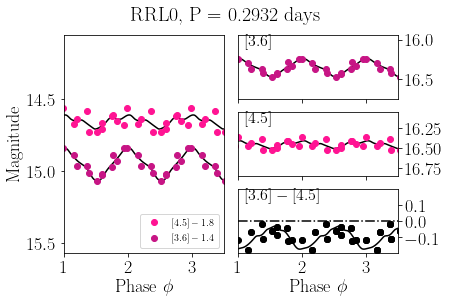

GLOESSpy results for P = 0.29322862:

mean_mag_ch1 = 16.349359
amplitude_ch1 = 0.22741578
mean_mag_ch2 = 16.453955
amplitude_ch2 = 0.097410498
mean_unc_ch1 = 0.18589115
mean_unc_ch2 = 0.29756487


RRL Catalogue ID: 1

Gaia source_id = 4418913218870688768

RRL has two periods: P0 = 0.45604927 and P1 = 0.3324599

Channel 1: No match found to main photometry file. Select different channel.

Channel 2 MAIN_ID: 626
GAIA ID: 4418913218870688768

RRL1  ---- Period = 0.4560492745060416 days
------------------------------------------------------
0 12
[16.19695209 16.20123319 16.3001887  16.31243259 16.27403741 16.32714476
 16.36759815 16.33267467 16.23731774 16.28658909 16.25588511 16.27331239]
(12,)
[0.0821664  0.23700677 0.35369796 0.4924431  0.62813275 0.77498328
 0.88786775 0.02960689 0.16587641 0.28518153 0.41855277 0.57155088]
(12,)
<[4.5]> = 16.289    std dev = 0.039     amplitude = 0.139


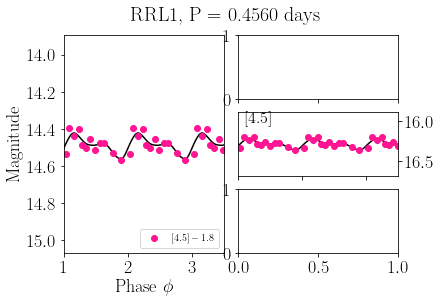

GLOESSpy results for P0 = 0.45604927:

mean_mag_ch1 = nan
amplitude_ch1 = nan
mean_mag_ch2 = 16.288856
amplitude_ch2 = 0.13903693

mean_unc_ch1 = nan
mean_unc_ch2 = 0.02839492


RRL1  ---- Period = 0.3324598951039927 days
------------------------------------------------------
0 12
[16.19695209 16.20123319 16.3001887  16.31243259 16.27403741 16.32714476
 16.36759815 16.33267467 16.23731774 16.28658909 16.25588511 16.27331239]
(12,)
[0.4318876  0.64428867 0.80435891 0.99468146 0.18081269 0.38225376
 0.53710215 0.73153172 0.91845837 0.08211425 0.2650652  0.47493916]
(12,)
<[4.5]> = 16.279    std dev = 0.009     amplitude = 0.030


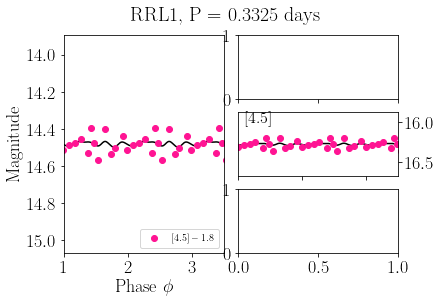

GLOESSpy results for P1 = 0.3324599:

mean_mag_ch1 = nan
amplitude_ch1 = nan
mean_mag_ch2 = 16.279408
amplitude_ch2 = 0.030373508

mean_unc_ch1 = nan
mean_unc_ch2 = 0.02839492


Select which Period provides the most clarity: 1 or 2

1
RRL Catalogue ID: 2

Gaia source_id = 4418726027016125056

RRL classification: RRc

Channel 1 MAIN_ID: 24
GAIA ID: 4418726027016125056

Channel 2 MAIN_ID: 95
GAIA ID: 4418726027016125056

RRL2  ---- Period = 0.32994609655420243 days
------------------------------------------------------
8 6
[16.36910084 99.         99.         16.21819261 16.21242382 16.31084447
 99.         99.         16.21384462 16.3189741  16.26661542 16.24143871]
(12,)
[0.44727228 0.66129159 0.82258137 0.01435396 0.20190329 0.4048791
 0.56090726 0.75681815 0.94516896 0.1100717  0.29441652 0.50588947]
(12,)
<[3.6]> = 16.232    std dev = 0.037     amplitude = 0.140
[99.         99.         16.38625076 99.         16.25975287 16.01539881
 99.         15.92720922 99.         16.26072457 

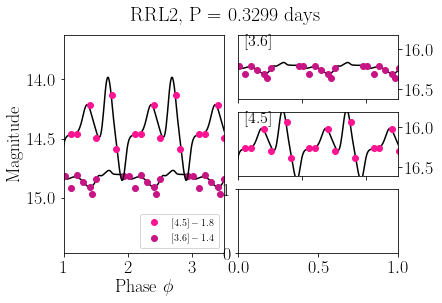

GLOESSpy results for P = 0.3299461:

mean_mag_ch1 = 16.2319
amplitude_ch1 = 0.14030118
mean_mag_ch2 = 16.211131
amplitude_ch2 = 0.8732754
mean_unc_ch1 = 0.063012173
mean_unc_ch2 = 0.043195269


RRL Catalogue ID: 3

Failed to find significant match to Gaia DR2 variable database: using catalogue stars.

Channel 1: No match found to main photometry file. Select different channel.

Channel 2 MAIN_ID: 227
GAIA ID: 4418726027016125056

RRL3  ---- Period = 0.2864 days
------------------------------------------------------
0 12
[16.53672729 16.44761833 16.47355256 16.45597237 16.46422854 16.5627579
 16.38728362 16.45727831 16.53499324 16.49645925 16.46392426 16.47243961]
(12,)
[0.36649124 0.61305143 0.79886474 0.01979567 0.2358612  0.46969876
 0.64945043 0.87514888 0.09213775 0.28211337 0.49448716 0.73811382]
(12,)
<[4.5]> = 16.483    std dev = 0.035     amplitude = 0.130


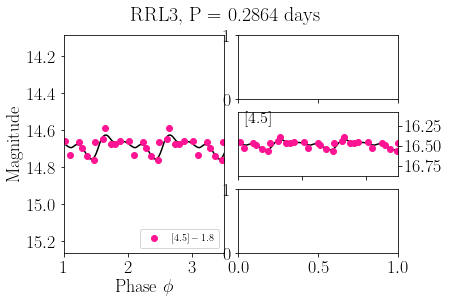

GLOESSpy results for P = 0.2864:

mean_mag_ch1 = nan
amplitude_ch1 = nan
mean_mag_ch2 = 16.482614
amplitude_ch2 = 0.12966511
mean_unc_ch1 = nan
mean_unc_ch2 = 0.044377961


RRL Catalogue ID: 4

Gaia source_id = 4418920808077110784

RRL classification: RRc

Channel 1 MAIN_ID: 568
GAIA ID: 4418920808077110784

Channel 2 MAIN_ID: 554
GAIA ID: 4418920808077110784

RRL4  ---- Period = 0.3379328972183922 days
------------------------------------------------------
12 12
[16.29050218 16.29246399 16.29352281 16.36382881 16.14366031 16.29666858
 16.32546585 16.35422774 16.24825446 16.20620327 16.32655656 16.33672076]
(12,)
[0.83304088 0.04200201 0.19947982 0.38672    0.56983674 0.76801536
 0.9203559  0.11163658 0.29553585 0.45654124 0.6365292  0.84300414]
(12,)
<[3.6]> = 16.266    std dev = 0.055     amplitude = 0.174
[16.29390318 16.45807446 16.37022933 16.38472677 16.30274203 16.31923652
 16.41884667 16.43379825 16.48143336 16.44196396 16.32985699 16.39757482]
(12,)
[0.83304088 0.04200201 0.19

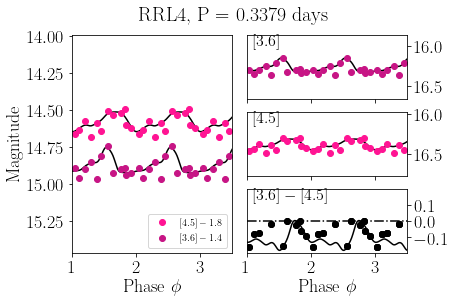

GLOESSpy results for P = 0.3379329:

mean_mag_ch1 = 16.266414
amplitude_ch1 = 0.17378526
mean_mag_ch2 = 16.375198
amplitude_ch2 = 0.13324725
mean_unc_ch1 = 0.090724176
mean_unc_ch2 = 0.13299195


RRL Catalogue ID: 5

Gaia source_id = 4418920846732620032

RRL classification: RRab

Channel 1 MAIN_ID: 523
GAIA ID: 4418920846732620032

Channel 2 MAIN_ID: 547
GAIA ID: 4418920846732620032

RRL5  ---- Period = 0.6432279274597504 days
------------------------------------------------------
12 12
[15.94876889 15.91031104 15.94477107 15.83537907 15.72613632 15.83631827
 15.92725686 15.80647466 15.87128584 15.85665125 15.81360661 15.8680773 ]
(12,)
[0.37688378 0.48666577 0.56939995 0.66777039 0.7639745  0.86809168
 0.94812688 0.04862009 0.14523531 0.22982277 0.32438312 0.43285894]
(12,)
<[3.6]> = 15.860    std dev = 0.039     amplitude = 0.147
[15.75033166 15.9285556  15.91281174 15.99297238 15.94598594 15.85773817
 15.81535308 15.950647   15.95092216 15.99340108 15.83813774 15.75547662]
(12,)
[0.

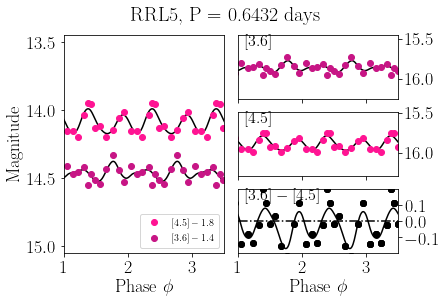

GLOESSpy results for P = 0.64322793:

mean_mag_ch1 = 15.860336
amplitude_ch1 = 0.14669852
mean_mag_ch2 = 15.894889
amplitude_ch2 = 0.18238985
mean_unc_ch1 = 0.076111363
mean_unc_ch2 = 0.094565226


RRL Catalogue ID: 6

Gaia source_id = 4418724034151291776

No match in DR2 variable stars!

4418724034151291776
4418920846732620032
Manual period required.

RRL classification: RRab

Channel 1: No match found to main photometry file. Select different channel.

Channel 2 MAIN_ID: 67
GAIA ID: 4418724034151291776

RRL6  ---- Period = 0.5517 days
------------------------------------------------------
0 10
[16.2504625  16.29208576 16.02486927 15.95936183 15.97793969 16.08602386
 99.         16.12645004 99.         16.40805638 16.49813303 15.95305156]
(12,)
[0.99830178 0.12629677 0.22275668 0.33744694 0.44961147 0.57100186
 0.66431503 0.78148022 0.89412408 0.99274473 0.10299279 0.22946492]
(12,)
<[4.5]> = 16.130    std dev = 0.140     amplitude = 0.448


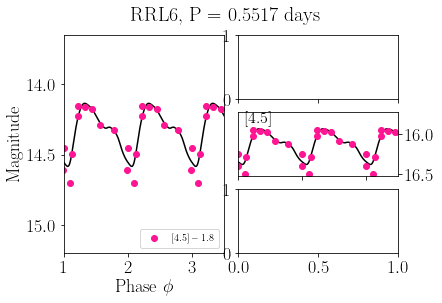

GLOESSpy results for P = 0.5517:

mean_mag_ch1 = nan
amplitude_ch1 = nan
mean_mag_ch2 = 16.129649
amplitude_ch2 = 0.44794543
mean_unc_ch1 = nan
mean_unc_ch2 = 0.03490245


Channel 1 results:
Average Mags:
[16.33935922 16.22190018 16.25641445 15.85033551]
Average Uncertainty (Mag):
[0.18589115 0.06301217 0.09072418 0.07611136]
Period:
[-0.10579364 -0.05455701 -0.04416953  0.10836489]

Channel 2 results:
Average Mags:
[16.445955   16.28085581 16.20313086 16.47461356 16.36719813 15.88688874
 16.12164923]
Average Uncertainty (Mag):
[0.29756487 0.02839492 0.04319527 0.04437796 0.13299195 0.09456523
 0.03490245]
Period:
[-0.10579364 -0.05126074 -0.05455701 -0.11602699 -0.04416953  0.10836489
  0.04170298]



In [17]:
## GLOESS LIGHT CURVES ##

# OPTIONS
cluster       = cluster_input
channel       = '4p5um'
epoch_path    = epoch_path
path1, path2  = epoch_path+cluster_input+'__e[0-9]_'+channel+'.fits', epoch_path+cluster+'__e[0-9][0-9]_'+channel+'.fits'

main_file_ch1 = 'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/'+cluster+'_main_phot_3p6um.txt'
main_file_ch2 = 'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/'+cluster+'_main_phot_4p5um.txt'

main_table1 = ascii.read(main_file_ch1, delimiter = ',', data_start = 1)
main_table2 = ascii.read(main_file_ch2, delimiter = ',', data_start = 1)

## REDO LIGHT CURVE X AXIS TO AVOID RUNNING ABOVE CODE ##
lctime = []

for file in glob.glob(path1) + glob.glob(path2):
    with fits.open(file) as hdr_list:
        e_hdr = hdr_list[0].header
        lctime.append(Time(e_hdr['DATE_OBS'], format = 'isot', scale = 'utc').mjd)

## READ IN GAIA DATA FOR STARS <10ARCMIN OF PAL5 ##

vot_file = 'gaia_data/'+cluster+'_data/gaia_dr2_PAL5_read.vot'
votable = parse_single_table(vot_file).to_table()
gaia_data = votable
print('Gaia - Variable stars around 10 arcmin of {0}:\n'.format(cluster))
print(gaia_data['source_id', 'ra', 'dec', 'parallax'])

## READ IN STAR CATALOGUE FROM CHRISTINE CLEMENT ##

rrl_cat = pd.read_csv('CCVS_data/CCVS_'+cluster+'_RRLs_data_readin.txt', sep = ',', header = 0)
print('RR Lyrae catalogue for {0}:\n'.format(cluster))
print(rrl_cat); print('\n')

## INITIALISE COORDINATE TRANSFORM/MATCHING ##

coord_rrl = SkyCoord(rrl_cat['ra_deg'], rrl_cat['dec_deg'], unit = u.degree)
coord_main1 = SkyCoord(main_table1['ra'], main_table1['dec'], unit = u.degree)
coord_main2 = SkyCoord(main_table2['ra'], main_table2['dec'], unit = u.degree)
coord_gaia = SkyCoord(gaia_data['ra'], gaia_data['dec'], unit = u.degree)

## LISTS FOR USE IN PL RELATIONS ##

av_mag1 = []
av_mag2 = []
av_unc1 = []
av_unc2 = []
period1 = []
period2 = []

## LOOP THROUGH ALL KNOWN RRLs AND PLOT LIGHT-CURVE ##
for i in range(len(rrl_cat)):
    target_rrl = i
    print('RRL Catalogue ID: {0}\n'.format(target_rrl))
    c = coord_rrl[target_rrl]
    
    source_id, d2d, d3d = c.match_to_catalog_sky(coord_gaia)
    rad = 0.25 * u.arcmin
    
    ## CHECK SIGNIFICANT MATCH TO GAIA DATA AROUND CLUSTER ##
    # THIS IS TO ENSURE WHETHER A GAIA PERIOD CAN BE USED OR A MANUAL
    # FIRST STATEMENT DEALS WITH SIGNIFICANT MATCHES
    # SECOND STATEMENT DEALS WITH USER INPUT PERIODS
    
    if (d2d < rad):
        
        gaia_source = gaia_data[source_id]['source_id']
        print('Gaia source_id = {0}\n'.format(gaia_source))
        
        ## READ IN ALL GAIA DR2 VARIABLE STARS [140784 stars] ##

        vot_file1 = 'gaia_data/'+cluster+'_data/gaia_dr2_rrls.vot'
        votable = parse_single_table(vot_file1).to_table()
        gaia_main = votable

        ## MATCH GAIA source_id TO STARS IDENTIFIED AROUND PAL5 ##

        for idx in range(len(gaia_main)):
            if gaia_main[idx]['source_id'] == gaia_source:
                main_id = idx
        if gaia_main[main_id]['source_id'] != gaia_source:
            print('No match in DR2 variable stars!\n')
            print(gaia_source)
            print(gaia_main[main_id]['source_id'])
            print('Manual period required.\n')

        ## EXTRACT PERIODS FROM GAIA DATA ##
        # IDENTIFY WHETHER FUNDAMENTAL OR FIRST OVERTONE OR BOTH
        # IF RRd TYPE THEN PLOTTING BOTH LIGHT CURVES REQUIRED
            # FIRST LEVEL EXTRACTS BOTH PERIODS, THEN CHECKS IF STAR PRESENT IN BOTH CHANNELS
                # PLOTS BOTH LIGHT CURVES AND ASKS USER INPUT AS TO WHICH LIGHT CURVE DATA TO ADD TO PL FIT LISTS
        # IF NOT RRd TYPE THEN JUST ONE LIGHT CURVE NEEDED
            # FIRST LEVEL EXTRACTS THE PERIOD, THEN CHECKS IF STAR PRESENT IN BOTH CHANNELS
            # ADDS DATA FOR EACH CHANNEL (WHERE POSSIBLE) TO PL FIT LISTS

        if gaia_main[main_id]['best_classification'] == b'RRd':
            if type(gaia_main[main_id]['pf']) == np.float64:
                P0 = gaia_main[main_id]['pf']
                P0_err = gaia_main[main_id]['pf_error']
            elif type(gaia_main[main_id]['pf']) == np.ma.core.MaskedConstant:
                pass
            if type(gaia_main[main_id]['p1_o']) == np.float64:
                P1 = gaia_main[main_id]['p1_o']
                P1_err = gaia_main[main_id]['p1_o_error']
            elif type(gaia_main[main_id]['p1_o']) == np.ma.core.MaskedConstant:
                pass
            print('RRL has two periods: P0 = {0:.8g} and P1 = {1:.8g}\n'.format(P0, P1))
            
            rrl_class = 'RRd'

            ## MATCH CATALOGUE TO MASTER SOURCE LIST ##
            
            main1_id, d2d, d3d = c.match_to_catalog_sky(coord_main1)
            main2_id, d2d2, d3d2 = c.match_to_catalog_sky(coord_main2)
            if (d2d > 0.5 * u.arcmin):
                multi = 0 # STAR NOT IN BOTH CHANNELS
                print('Channel 1: No match found to main photometry file. Select different channel.\n')
                print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))
            else:
                multi = 1 # STAR IS IN BOTH CHANNELS
                print('Channel 1 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main1_id, gaia_source))
                print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))
            
            ## FILL TABLE WITH 99 DUMMY INTS FOR GLOESS ##
            
            main_table1_m = copy.copy(main_table1.filled(99))
            main_table2_m = copy.copy(main_table2.filled(99))

            mag1 = []
            unc1 = []
            mag2 = []
            unc2 = []

            for i in range(1, 13):
                if multi == 1:
                    mag1.append(main_table1_m[main1_id]['mag_e'+str(i)])
                    unc1.append(main_table1_m[main1_id]['unc_e'+str(i)])
                if (multi == 0 or multi == 1):
                    mag2.append(main_table2_m[main2_id]['mag_e'+str(i)])
                    unc2.append(main_table2_m[main2_id]['unc_e'+str(i)])

            unc1 = np.array(unc1)
            unc2 = np.array(unc2)
            
            av_unc1_inter, av_unc2_inter = 0, 0
            
            if len(unc1) != 0:
                for i in range(len(unc1)):
                    av_unc1_inter += unc1[i]
                av_unc1_inter = av_unc1_inter / len(unc1)
            elif len(unc1) == 0:
                av_unc1_inter = float('NaN')
            
            for i in range(len(unc2)):
                av_unc2_inter += unc2[i]
                
            av_unc2_inter = av_unc2_inter / len(unc2)

            av_1a, am_1a, av_2a, am_2a = GLOESSpy(mag1, unc1, mag2, unc2, lctime, P0, 'RRL'+str(target_rrl), multi)
            
            print('GLOESSpy results for P0 = {0:.8g}:\n'.format(P0))
            print('mean_mag_ch1 = {0:.8g}\namplitude_ch1 = {1:.8g}\nmean_mag_ch2 = {2:.8g}\namplitude_ch2 = {3:.8g}\n'.format(av_1a, am_1a, av_2a, am_2a))
            print('mean_unc_ch1 = {0:.8g}\nmean_unc_ch2 = {1:.8g}'.format(av_unc1_inter, av_unc2_inter)); print('\n')
            
            av_1b, am_1b, av_2b, am_2b = GLOESSpy(mag1, unc1, mag2, unc2, lctime, P1, 'RRL'+str(target_rrl), multi)
            
            print('GLOESSpy results for P1 = {0:.8g}:\n'.format(P1))
            print('mean_mag_ch1 = {0:.8g}\namplitude_ch1 = {1:.8g}\nmean_mag_ch2 = {2:.8g}\namplitude_ch2 = {3:.8g}\n'.format(av_1b, am_1b, av_2b, am_2b))
            print('mean_unc_ch1 = {0:.8g}\nmean_unc_ch2 = {1:.8g}'.format(av_unc1_inter, av_unc2_inter)); print('\n')
            
            ## CHECK WHETHER PERIOD MUST BE FUNDAMENTALISED ##
            if rrl_class == 'RRd':
                P1 = np.log10(P1) + 0.127 + 0.3
            
            while True:
                print('Select which Period provides the most clarity: 1 or 2\n')
                sel = int(input())
                
                ## EXTRACTING THE VALUES FOR THE BEST LIGHT CURVE ##
                if sel == 1:
                    if np.isnan(av_1a) == True:
                        P_nan = float('nan')
                        av_mag1.append(av_1a)
                        av_unc1.append(av_unc1_inter)
                        period1.append(P_nan)
                    else:
                        av_mag1.append(av_1a)
                        av_unc1.append(av_unc1_inter)
                        period1.append(P1)
                        
                    av_mag2.append(av_2a)
                    av_unc2.append(av_unc2_inter)
                    period2.append(P1)
                elif sel == 2:
                    if np.isnan(av_1b) == True:
                        P_nan = float('nan')
                        av_mag1.append(av_1a)
                        av_unc1.append(av_unc1_inter)
                        period1.append(P_nan)
                    else:
                        av_mag1.append(av_1b)
                        av_unc1.append(av_unc1_inter)
                        period1.append(P1)
                        
                    av_mag2.append(av_2b)
                    av_unc2.append(av_unc2_inter)
                    period2.append(P1)
                break
            
        elif gaia_main[main_id]['best_classification'] != b'RRd':
            if type(gaia_main[main_id]['pf']) == np.float64:
                rrl_class = 'RRab'
                P = gaia_main[main_id]['pf']
                P_err = gaia_main[main_id]['pf_error']
            elif type(gaia_main[main_id]['pf']) == np.ma.core.MaskedConstant:
                pass
            if type(gaia_main[main_id]['p1_o']) == np.float64:
                rrl_class = 'RRc'
                P = gaia_main[main_id]['p1_o']
                P_err = gaia_main[main_id]['p1_o_error']
            elif type(gaia_main[main_id]['p1_o']) == np.ma.core.MaskedConstant:
                pass
            print('RRL classification: {0}\n'.format(rrl_class))

            ## USE PERIOD FROM CHRISTINE'S CATALOGUE IF STAR NOT FOUND IN GAIA OR INCORRECTLY MATCHED ##
            if gaia_main[main_id]['source_id'] != gaia_source:
                P = rrl_cat['period'][target_rrl]

            ## MATCH CATALOGUE TO MASTER SOURCE LIST ##

            main1_id, d2d, d3d = c.match_to_catalog_sky(coord_main1)
            main2_id, d2d2, d3d2 = c.match_to_catalog_sky(coord_main2)
            
            if (d2d > 0.5 * u.arcmin):
                multi = 0 # STAR NOT IN BOTH CHANNELS
                print('Channel 1: No match found to main photometry file. Select different channel.\n')
                print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))
            else:
                multi = 1 # STAR IS IN BOTH CHANNELS
                print('Channel 1 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main1_id, gaia_source))
                print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))
                
            ## FILL TABLE WITH 99 DUMMY INTS FOR GLOESS ##
            
            main_table1_m = copy.copy(main_table1.filled(99))
            main_table2_m = copy.copy(main_table2.filled(99))

            mag1 = []
            unc1 = []
            mag2 = []
            unc2 = []

            for i in range(1, 13):
                if multi == 1:
                    mag1.append(main_table1_m[main1_id]['mag_e'+str(i)])
                    unc1.append(main_table1_m[main1_id]['unc_e'+str(i)])
                if (multi == 0 or multi == 1):
                    mag2.append(main_table2_m[main2_id]['mag_e'+str(i)])
                    unc2.append(main_table2_m[main2_id]['unc_e'+str(i)])

            unc1 = np.ma.array(unc1)
            unc1 = np.ma.masked_where(unc1 == 99., unc1)
            unc2 = np.ma.array(unc2)
            unc2 = np.ma.masked_where(unc2 == 99., unc2)

            unc1_ma = []
            unc2_ma = []

            for i in range(len(unc1)):
                if type(unc1[i]) != np.ma.core.MaskedConstant:
                    unc1_ma.append(unc1[i])
            for i in range(len(unc2)):
                if type(unc2[i]) != np.ma.core.MaskedConstant:
                    unc2_ma.append(unc2[i])

            unc1_ma, unc2_ma = np.array(unc1_ma), np.array(unc2_ma)
            
            av_unc1_inter, av_unc2_inter = 0, 0
            
            if len(unc1_ma) != 0:
                for i in range(len(unc1_ma)):
                    av_unc1_inter += unc1_ma[i]
                av_unc1_inter = av_unc1_inter / len(unc1_ma)
            elif len(unc1_ma) == 0:
                av_unc1_inter = float('NaN')                    
          
            for i in range(len(unc2_ma)):
                av_unc2_inter += unc2_ma[i]
                
            av_unc2_inter = av_unc2_inter / len(unc2_ma)

            av_1, am_1, av_2, am_2 = GLOESSpy(mag1, unc1, mag2, unc2, lctime, P, 'RRL'+str(target_rrl), multi)
            
            print('GLOESSpy results for P = {0:.8g}:\n'.format(P))
            print('mean_mag_ch1 = {0:.8g}\namplitude_ch1 = {1:.8g}\nmean_mag_ch2 = {2:.8g}\namplitude_ch2 = {3:.8g}'.format(av_1, am_1, av_2, am_2))
            print('mean_unc_ch1 = {0:.8g}\nmean_unc_ch2 = {1:.8g}'.format(av_unc1_inter, av_unc2_inter)); print('\n')
            
            ## CHECK WHETHER PERIOD NEEDS TO BE FUNDAMENTALISED ##
            if rrl_class == 'RRab':
                P = np.log10(P) + 0.3
            elif rrl_class == 'RRc':
                P = np.log10(P) + 0.127 + 0.3
            
            ## EXTRACT THE VALUES AND APPEND TO LIGHT CURVE LISTS ##
            if np.isnan(av_1) == True:
                P1 = float('nan')
                av_mag1.append(av_1)
                av_unc1.append(av_unc1_inter)
                period1.append(P1)
            else:
                av_mag1.append(av_1)
                av_unc1.append(av_unc1_inter)
                period1.append(P)
                        
            av_mag2.append(av_2)
            av_unc2.append(av_unc2_inter)
            period2.append(P)
    else:
        print('Failed to find significant match to Gaia DR2 variable database: using catalogue stars.\n')
        P = rrl_cat['period'][target_rrl]
        
        ## MATCH CATALOGUE TO MASTER SOURCE LIST ##

        main1_id, d2d, d3d = c.match_to_catalog_sky(coord_main1)
        main2_id, d2d2, d3d2 = c.match_to_catalog_sky(coord_main2)
            
        if (d2d > 0.5 * u.arcmin):
            multi = 0 # STAR NOT IN BOTH CHANNELS
            print('Channel 1: No match found to main photometry file. Select different channel.\n')
            print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))
        else:
            multi = 1 # STAR IS IN BOTH CHANNELS
            print('Channel 1 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main1_id, gaia_source))
            print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))
                
        ## FILL TABLE WITH 99 DUMMY INTS FOR GLOESS ##
            
        main_table1_m = copy.copy(main_table1.filled(99))
        main_table2_m = copy.copy(main_table2.filled(99))

        mag1 = []
        unc1 = []
        mag2 = []
        unc2 = []

        for i in range(1, 13):
            if multi == 1:
                mag1.append(main_table1_m[main1_id]['mag_e'+str(i)])
                unc1.append(main_table1_m[main1_id]['unc_e'+str(i)])
            if (multi == 0 or multi == 1):
                mag2.append(main_table2_m[main2_id]['mag_e'+str(i)])
                unc2.append(main_table2_m[main2_id]['unc_e'+str(i)])
        
        unc1 = np.ma.array(unc1)
        unc1 = np.ma.masked_where(unc1 == 99., unc1)
        unc2 = np.ma.array(unc2)
        unc2 = np.ma.masked_where(unc2 == 99., unc2)

        unc1_ma = []
        unc2_ma = []

        for i in range(len(unc1)):
            if type(unc1[i]) != np.ma.core.MaskedConstant:
                unc1_ma.append(unc1[i])
        for i in range(len(unc2)):
            if type(unc2[i]) != np.ma.core.MaskedConstant:
                unc2_ma.append(unc2[i])

        unc1_ma, unc2_ma = np.array(unc1_ma), np.array(unc2_ma)
            
        av_unc1_inter, av_unc2_inter = 0, 0
            
        if len(unc1_ma) != 0:
            for i in range(len(unc1_ma)):
                av_unc1_inter += unc1_ma[i]
            av_unc1_inter = av_unc1_inter / len(unc1_ma)
        elif len(unc1_ma) == 0:
            av_unc1_inter = float('NaN')
            
        for i in range(len(unc2_ma)):
            av_unc2_inter += unc2_ma[i]
                
        av_unc2_inter = av_unc2_inter / len(unc2_ma)

        av_1, am_1, av_2, am_2 = GLOESSpy(mag1, unc1, mag2, unc2, lctime, P, 'RRL'+str(target_rrl), multi)
            
        print('GLOESSpy results for P = {0:.8g}:\n'.format(P))
        print('mean_mag_ch1 = {0:.8g}\namplitude_ch1 = {1:.8g}\nmean_mag_ch2 = {2:.8g}\namplitude_ch2 = {3:.8g}'.format(av_1, am_1, av_2, am_2))
        print('mean_unc_ch1 = {0:.8g}\nmean_unc_ch2 = {1:.8g}'.format(av_unc1_inter, av_unc2_inter)); print('\n')
            
        ## CHECK WHETHER PERIOD MUST BE FUNDAMENTALISED ##
        if rrl_cat['type'][target_rrl] == 'RR0':
            P = np.log10(P) + 0.3
        elif rrl_cat['type'][target_rrl] == 'RR1':
            P = np.log10(P) + 0.127 + 0.3
        
        ## EXTRACT THE VALUES AND APPEND TO LIGHT CURVE LISTS ##

        if np.isnan(av_1) == True:
            P1 = float('nan')
            av_mag1.append(av_1)
            av_unc1.append(av_unc1_inter)
            period1.append(P1)
        else:
            P1 = P
            av_mag1.append(av_1)
            av_unc1.append(av_unc1_inter)
            period1.append(P1)
                        
        av_mag2.append(av_2)
        av_unc2.append(av_unc2_inter)
        period2.append(P)
        
## REMOVING NANS FROM RESULTS ##

av_mag1, av_unc1, period1 = np.array(av_mag1), np.array(av_unc1), np.array(period1)
av_mag2, av_unc2, period2 = np.array(av_mag2), np.array(av_unc2), np.array(period2)

def NaNmask(data):
    mask = ~np.isnan(data)
    result = data[mask]
    return result

av_mag1 = NaNmask(av_mag1)
av_unc1 = NaNmask(av_unc1)
av_mag2 = NaNmask(av_mag2)
av_unc2 = NaNmask(av_unc2)
period1 = NaNmask(period1)
period2 = NaNmask(period2)

## EXTINCTION CORRECTION ##
# NOTE: AS STARS OCCUPY AREA OF LOWER RESOLUTION THAN DUST MAP (CHECKED), FUNCTION WILL AUTO SUBTRACT THE FINAL EXT. VALUE
def extinction_corr(star_table, data1, data2):
    stars = star_table
    for i in range(len(stars)):
        ra = stars['ra_deg'][i]
        dec = stars['dec_deg'][i]
        #print('Coords: ra = {0} d, dec = {1} d\n'.format(ra, dec))
        c = SkyCoord(ra, dec, unit = u.degree, frame = 'icrs')
        table = IrsaDust.get_extinction_table(c)
        irac1_ext = table[19][3]
        irac2_ext = table[20][3]

    data_in1 = data1
    data_in2 = data2
    data_out1 = data_in1 - irac1_ext
    data_out2 = data_in2 - irac2_ext
    return data_out1, data_out2

av_mag1, av_mag2 = extinction_corr(rrl_cat, av_mag1, av_mag2)

print('Channel 1 results:\nAverage Mags:\n{0}\nAverage Uncertainty (Mag):\n{1}\nPeriod:\n{2}\n'
      .format(av_mag1,av_unc1,period1))
print('Channel 2 results:\nAverage Mags:\n{0}\nAverage Uncertainty (Mag):\n{1}\nPeriod:\n{2}\n'
      .format(av_mag2,av_unc2,period2))

##### Fit PL relations

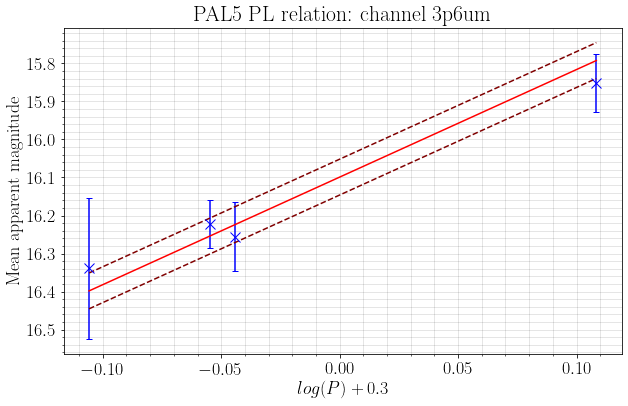

Intercept a₂             = 16.10 ± 0.03
Distance modulus a₂ - a₁ = 16.51 ± 0.04 (random) ± 0.12 (systematic)
Distance to PAL5         = 20.04 ± 0.37 (random) ± 1.11 (systematic) kpc


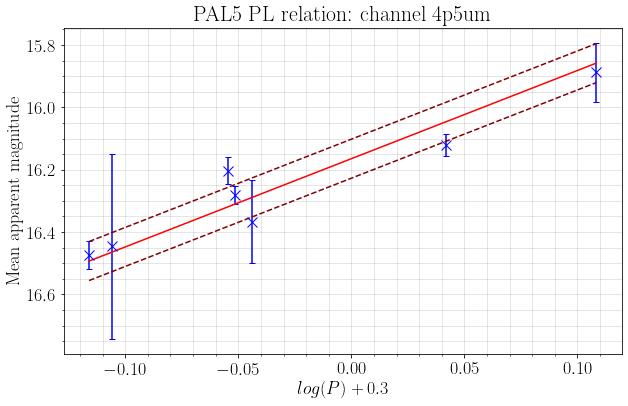

Intercept a₂             = 16.10 ± 0.03
Distance modulus a₂ - a₁ = 16.57 ± 0.04 (random) ± 0.12 (systematic)
Distance to PAL5         = 20.65 ± 0.37 (random) ± 1.15 (systematic) kpc


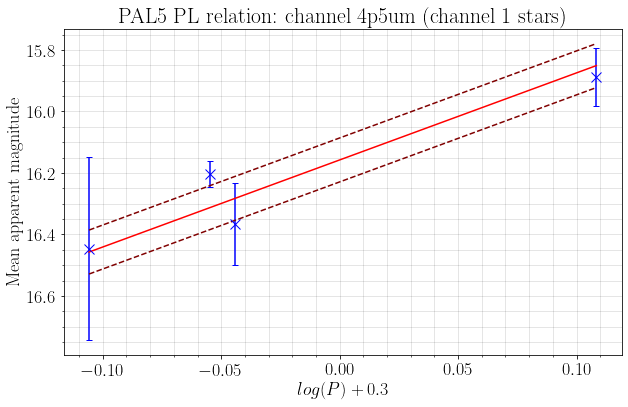

Intercept a₂             = 16.10 ± 0.03
Distance modulus a₂ - a₁ = 16.57 ± 0.05 (random) ± 0.12 (systematic)
Distance to PAL5         = 20.59 ± 0.48 (random) ± 1.15 (systematic) kpc


In [33]:
## FIT PARAMETERS ##

if (channel == 1) or (channel == '3p6um'):
    a1     = -0.40    ## VALUES FROM: NEELEY ET AL. 2019
    a1_unc = 0.03
    b      = -2.78
    b_unc  = 0.38
if (channel == 2) or (channel == '4p5um'):
    a1     = -0.41    ## VALUES FROM: NEELEY ET AL. 2019
    a1_unc = 0.03
    b      = -2.83
    b_unc  = 0.39

## FUNCTIONS FOR FIT AND DISTANCE ##

def func(P, intercept):
    return intercept + b * P

def distance(a1, a2):
    a1 = a1
    a2 = a2
    d = 10 ** (1 + (a2 - a1) / 5)
    return d

##_________________##
## FIT : CHANNEL 1 ##

channel = '3p6um'

## FIT PL RELATION ##

popt, pcov = curve_fit(func, period1, av_mag1)

a2 = popt[0]
a2_unc = np.sqrt(float(pcov[0][0]))

## STANDARD DEVIATION OF POINTS ABOUT THE PL FIT ##
std_dev1 = 0
for i in range(len(av_mag1)):
    std_dev1 += (av_mag1[i] - (a2 + b * period1[i]))**2
std_dev1 = np.sqrt(std_dev1 / len(av_mag1))

fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(period1, av_mag1, xerr = None, yerr = av_unc1, marker = 'x', color = 'blue', markersize = 10, capsize = 3, linestyle = 'None')
ax.set_xlabel(r'${log(P) + 0.3}$')
ax.set_ylabel('Mean apparent magnitude')
x = np.linspace(min(period1), max(period1), 100)
y = np.linspace(min(period1), max(period1), 100)
ax.plot(y, y * b + (a2 + std_dev1), linestyle = '--', color = 'maroon')
ax.plot(y, y * b + (a2 - std_dev1), linestyle = '--', color = 'maroon')
ax.plot(x, x * b + a2, linestyle = '-', color = 'red')
plt.title('{0} PL relation: channel {1}'.format(cluster, channel))
plt.minorticks_on()
plt.grid(b = True, which = 'major', lw = .5, alpha = .2, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, alpha = .2, color = 'black')
plt.gca().invert_yaxis()
savename = 'pl_relations/pl_relation_'+str(cluster)+'_'+str(channel)
plt.savefig(savename)
plt.show()
plt.close()

modulus = a2 - a1

d = distance(a1, a2) / 1000

## UNCERTAINTY CALCULATIONS ##

## RANDOM UNCERTAINTY IN DISTANCE MODULUS: u ##

sigma_u = np.sqrt(a1_unc**2 + a2_unc**2)
# PROPAGATE THROUGH TO DISTANCE: d
sigma_d = d * (np.log(10) * sigma_u / 5)

## SYSTEMATIC UNCERTAINTY IN DISTANCE MODULUS (FROM PL FIT): u ##

sigma_u_sys = np.sqrt(a1_unc**2 + (0.3 * b_unc)**2)
# PROPAGATE THROUGH TO DISTANCE: d
sigma_d_sys = d * (np.log(10) * sigma_u_sys / 5)

print('Intercept a\N{SUBSCRIPT TWO}             = {0:.2f} ± {1:.2f}'.format(intercept, intercept_unc))
print('Distance modulus a\N{SUBSCRIPT TWO} - a\N{SUBSCRIPT ONE} = {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(modulus, sigma_u, sigma_u_sys))
print('Distance to {0}         = {1:.4g} ± {2:.2f} (random) ± {3:.2f} (systematic) kpc'.format(cluster, d, sigma_d, sigma_d_sys))

##_________________##
## FIT : CHANNEL 2 ##

channel = '4p5um'

## FIT PL RELATION ##

popt, pcov = curve_fit(func, period2, av_mag2)

a2 = popt[0]
a2_unc = np.sqrt(float(pcov[0][0]))

## STANDARD DEVIATION OF POINTS ABOUT THE PL FIT ##
std_dev2 = 0
for i in range(len(av_mag2)):
    std_dev2 += (av_mag2[i] - (a2 + b * period2[i]))**2
std_dev2 = np.sqrt(std_dev2 / len(av_mag2))

fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(period2, av_mag2, xerr = None, yerr = av_unc2, marker = 'x', color = 'blue', markersize = 10, capsize = 3, linestyle = 'None')
ax.set_xlabel(r'${log(P) + 0.3}$')
ax.set_ylabel('Mean apparent magnitude')
x = np.linspace(min(period2), max(period2), 100)
y = np.linspace(min(period2), max(period2), 100)
ax.plot(y, y * b + (a2 + std_dev2), linestyle = '--', color = 'maroon')
ax.plot(y, y * b + (a2 - std_dev2), linestyle = '--', color = 'maroon')
ax.plot(x, x * b + a2, linestyle = '-', color = 'red')
plt.title('{0} PL relation: channel {1}'.format(cluster, channel))
plt.minorticks_on()
plt.grid(b = True, which = 'major', lw = .5, alpha = .2, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, alpha = .2, color = 'black')
plt.gca().invert_yaxis()
savename = 'pl_relations/pl_relation_'+str(cluster)+'_'+str(channel)
plt.savefig(savename)
plt.show()
plt.close()

modulus = a2 - a1

d = distance(a1, a2) / 1000

## UNCERTAINTY CALCULATIONS ##

## RANDOM UNCERTAINTY IN DISTANCE MODULUS: u ##

sigma_u = np.sqrt(a1_unc**2 + a2_unc**2)
# PROPAGATE THROUGH TO DISTANCE: d
sigma_d = d * (np.log(10) * sigma_u / 5)

## SYSTEMATIC UNCERTAINTY IN DISTANCE MODULUS (FROM PL FIT): u ##

sigma_u_sys = np.sqrt(a1_unc**2 + (0.3 * b_unc)**2)
# PROPAGATE THROUGH TO DISTANCE: d
sigma_d_sys = d * (np.log(10) * sigma_u_sys / 5)

print('Intercept a\N{SUBSCRIPT TWO}             = {0:.2f} ± {1:.2f}'.format(intercept, intercept_unc))
print('Distance modulus a\N{SUBSCRIPT TWO} - a\N{SUBSCRIPT ONE} = {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(modulus, sigma_u, sigma_u_sys))
print('Distance to {0}         = {1:.4g} ± {2:.2f} (random) ± {3:.2f} (systematic) kpc'.format(cluster, d, sigma_d, sigma_d_sys))

##__________________##
## FIT : CHANNEL 2a ##

channel = '4p5um'

## OBTAIN STARS COMMON TO BOTH CHANNELS ##

period3 = []
av_mag3 = []
av_unc3 = []

for i in range(len(period2)):
    for j in range(len(period1)):
        if period1[[j]] == period2[[i]]:
            period3.append(period1[j])
            av_mag3.append(av_mag2[i])
            av_unc3.append(av_unc2[i])

av_mag3, av_unc3, period3 = np.array(av_mag3), np.array(av_unc3), np.array(period3)

## FIT PL RELATION ##

popt, pcov = curve_fit(func, period3, av_mag3)

a2 = popt[0]
a2_unc = np.sqrt(float(pcov[0][0]))

## STANDARD DEVIATION OF POINTS ABOUT THE PL FIT ##
std_dev3 = 0
for i in range(len(av_mag3)):
    std_dev3 += (av_mag3[i] - (a2 + b * period3[i]))**2
std_dev3 = np.sqrt(std_dev3 / len(av_mag3))

fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(period3, av_mag3, xerr = None, yerr = av_unc3, marker = 'x', color = 'blue', markersize = 10, capsize = 3, linestyle = 'None')
ax.set_xlabel(r'${log(P) + 0.3}$')
ax.set_ylabel('Mean apparent magnitude')
x = np.linspace(min(period3), max(period3), 100)
y = np.linspace(min(period3), max(period3), 100)
ax.plot(y, y * b + (a2 + std_dev3), linestyle = '--', color = 'maroon')
ax.plot(y, y * b + (a2 - std_dev3), linestyle = '--', color = 'maroon')
ax.plot(x, x * b + a2, linestyle = '-', color = 'red')
plt.title('{0} PL relation: channel {1} (channel 1 stars)'.format(cluster, channel))
plt.minorticks_on()
plt.grid(b = True, which = 'major', lw = .5, alpha = .2, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, alpha = .2, color = 'black')
plt.gca().invert_yaxis()
savename = 'pl_relations/pl_relation_'+str(cluster)+'_'+str(channel)+'ch1_combined_ch2'
plt.savefig(savename)
plt.show()
plt.close()

modulus = a2 - a1

d = distance(a1, a2) / 1000

## UNCERTAINTY CALCULATIONS ##

## RANDOM UNCERTAINTY IN DISTANCE MODULUS: u ##

sigma_u = np.sqrt(a1_unc**2 + a2_unc**2)
# PROPAGATE THROUGH TO DISTANCE: d
sigma_d = d * (np.log(10) * sigma_u / 5)

## SYSTEMATIC UNCERTAINTY IN DISTANCE MODULUS (FROM PL FIT): u ##

sigma_u_sys = np.sqrt(a1_unc**2 + (0.3 * b_unc)**2)
# PROPAGATE THROUGH TO DISTANCE: d
sigma_d_sys = d * (np.log(10) * sigma_u_sys / 5)

print('Intercept a\N{SUBSCRIPT TWO}             = {0:.2f} ± {1:.2f}'.format(intercept, intercept_unc))
print('Distance modulus a\N{SUBSCRIPT TWO} - a\N{SUBSCRIPT ONE} = {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(modulus, sigma_u, sigma_u_sys))
print('Distance to {0}         = {1:.4g} ± {2:.2f} (random) ± {3:.2f} (systematic) kpc'.format(cluster, d, sigma_d, sigma_d_sys))